<a href="https://colab.research.google.com/github/whtan88/RandomDataAnalyst_DataAnalysis/blob/main/Kaggle_Credit_Card_Fraud_Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
In the real world, there is significant dataset imbalance. One such case is credit card fraud. There are ways such as SMOTE to overcome dataset imbalance, but what if such techniques are not available?

In this notebook, we will use Isolation Forest to address the dataset imbalance problem.

# Importing Libraries
Below is the list of libraries which we will be using in this notebook.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import precision_recall_curve, auc

# Downloading Kaggle Dataset

Below is a set of code which is used to connect via Kaggle API to download the dataset to be used.

We will be using the dataset of Credit Card Fraud Detection by the Machine Learning Group. It contains anonymized credit card transactions made by credit cards in September 2013 by European cardholders. It is labeled as either fraudulent or genuine.

The link to the dataset is as follows: [Credit Card Fraud Data](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "creditcard.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df.head()

<ipython-input-2-0234b3352263>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis (EDA)
Once the table is loaded, we can start our EDA and see what data is available. From the column headings, we can see that there are 3 easily readable columns, Time, Amount and Class, while the rest are denoted V with a numerical value from 1 through to 28.

Time stands for the number of seconds elapsed between this transaction and the first transaction in the dataset.

Amount stands for the transaction amount, which I can only assume to be denominated in the same currency.

Class is the label, 0 for genuine transaction while 1 for fraud label.

The rest of the columns V1 - V28 are principal components obtained with PCA. Due to confidentiality issues, the original features and  background information on the data are not provided by the data owner.

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

We can see that there is severe class imbalance, where the number of fraud labels is only 0.17% of the dataset. This is quite common in real life, as there are significantly lesser fraudulent transactions compared to genuine transactions.

In [ ]:
print(df.Class.value_counts())
print(f"% of fraud labels : {round(100*len(df[df['Class']==1])/len(df),2)}%")

Class
0    284315
1       492
Name: count, dtype: int64
% of fraud labels : 0.17%


Let's inspect to see if there are any missing values. Seems like there are none from the below results.

In [ ]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Next, we will take a quick look at the high level distribution of the dataset available. As expected, the Time and Amount columns are the raw data, with no preprocessing. The PCA columns from V1 through to V28 seems to have been preprocessed and scaled to an extent. As we do not have visibility into what is done with the PCA columns, we will leave them as they are.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Creating 2 additional dataframes by labels and inspecting the fraud labels
df_0 = df[df['Class'] == 0].copy()
df_1 = df[df['Class'] == 1].copy()
df_1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


# Graphical visualization of data
We have seen a high level view of the data. We can proceed to plot the histogram graphs of each variable to see how the data is distributed. We will compare the distribution of the genuine vs the distribution of the fraud to see if there is any way to clearly distinct between them.

In [ ]:
# Preparing to plot the columns to visually inspect the distribution of data
list_col = [6,12,18,24,30]
def plot_hist(r,i):
  axs[r, 0].hist(df_0[df_0.columns[i]])
  axs[r, 0].set_title(f'{df_0.columns[i]} - Genuine')
  axs[r, 1].hist(df_1[df_1.columns[i]])
  axs[r, 1].set_title(f'{df_1.columns[i]} - Fraud')

We will look at the first 6 columns in the dataset, Time, V1 - V6. We can see that there is general overlap in values across the variables for both the genuine and fraud labels.

Interestingly, it seems like some of the PCA variables have a distinct distribution which seems likely to differentiate between genuine and fraudulent transactions. I will indicate some of the observations I noticed below.

V1 : Fraudulent transactions appears to be negatively skewed, but there are some outliers for Genuine transactions.

V2 : Genuine transactions appear to be clustered around 0, with outliers appearing, while fraudulent transactions seem to have an approximate normal distribution about 0.

V3 : Same observation as V1.

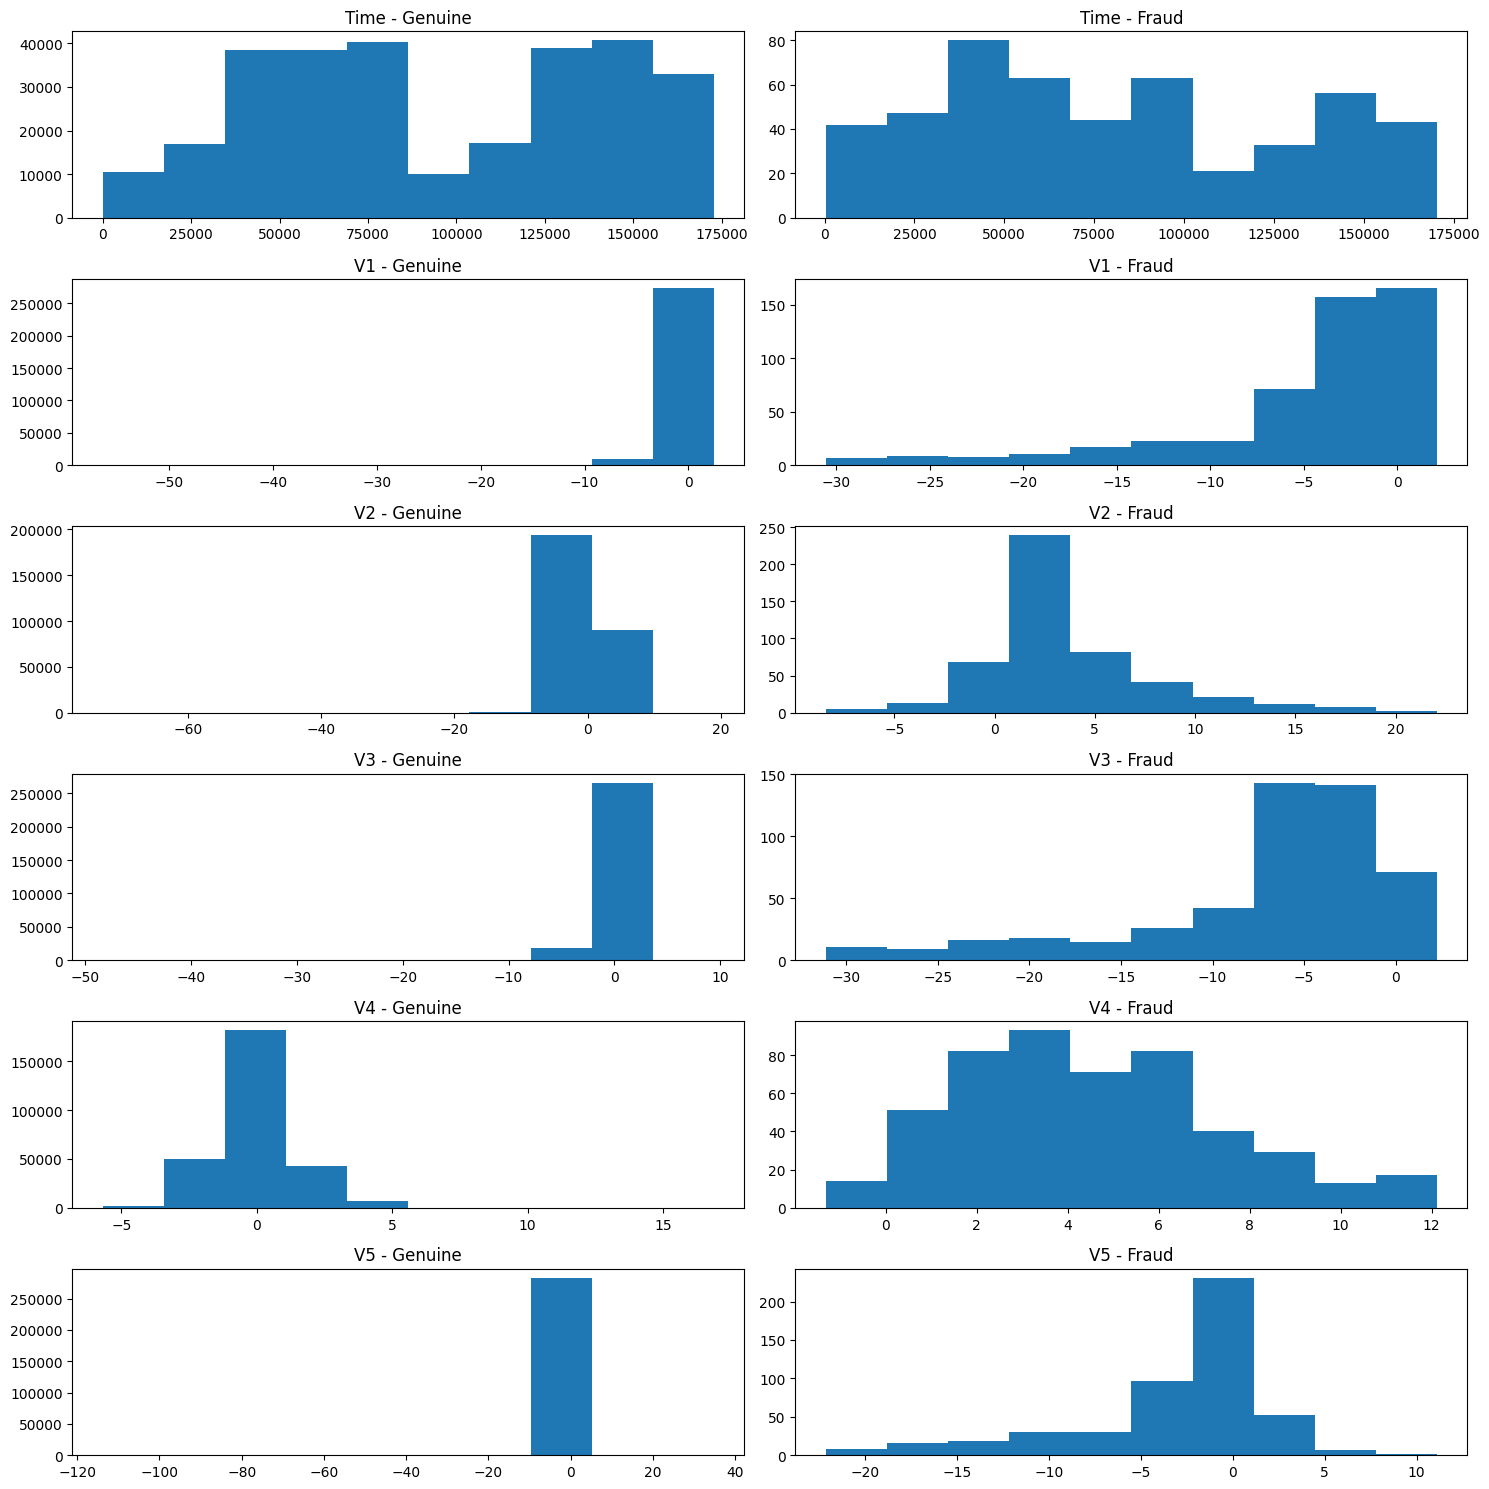

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
for i in range(0,list_col[0]):
  r = (i - list_col[1]) % 6
  plot_hist(r,i)
  fig.tight_layout()

V11 - Seems plausible to be a good variable to distinct between genuine and fraudulent transactions. THere is only a slight overlap in distribution, with fraudulent transactions being slightly more positive though there are positive outliers for genuine transactions.

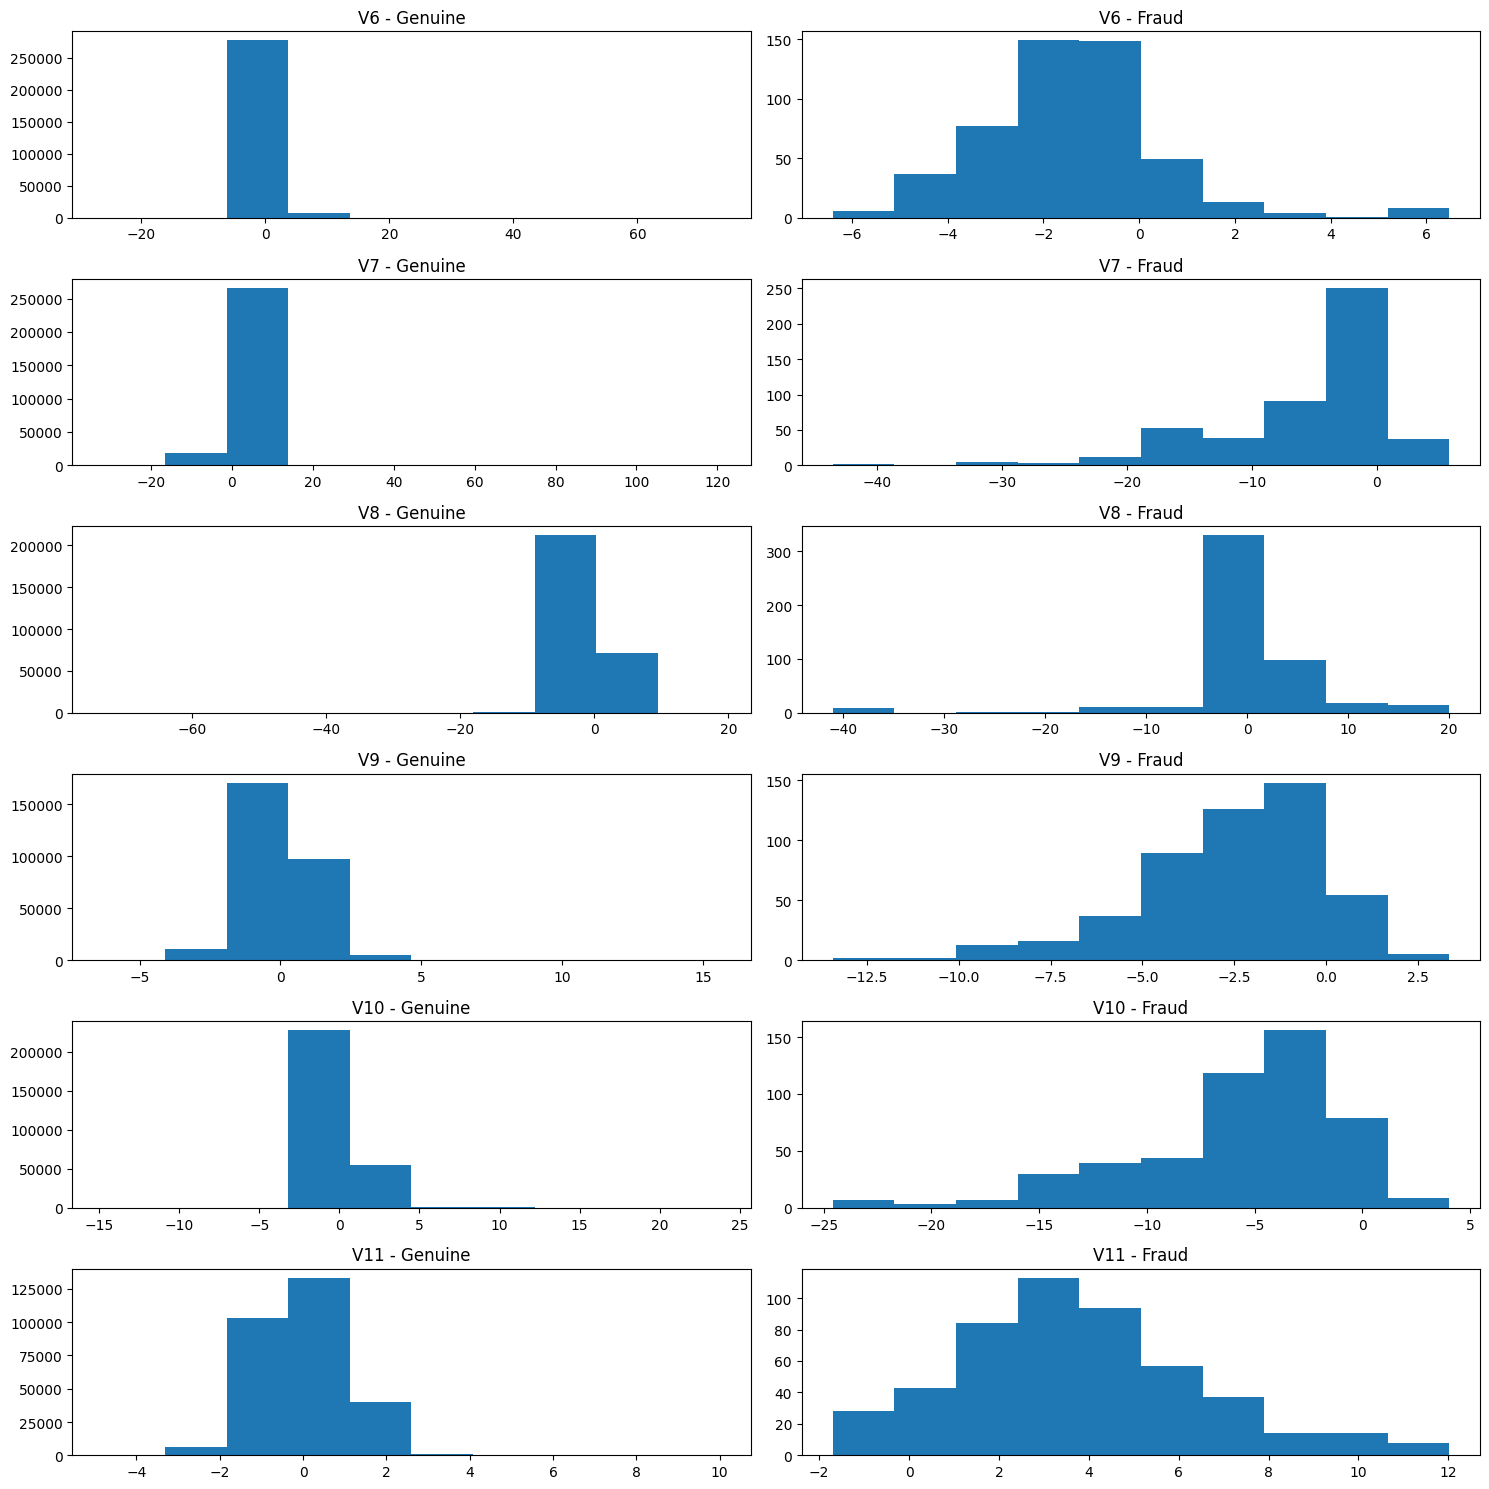

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
for i in range(list_col[0],list_col[1]):
  r = (i - list_col[1]) % 6
  plot_hist(r,i)
  fig.tight_layout()

V14 : Seems like another potentially good indicator for fraudulent transactions with minimal overlap of distribution.

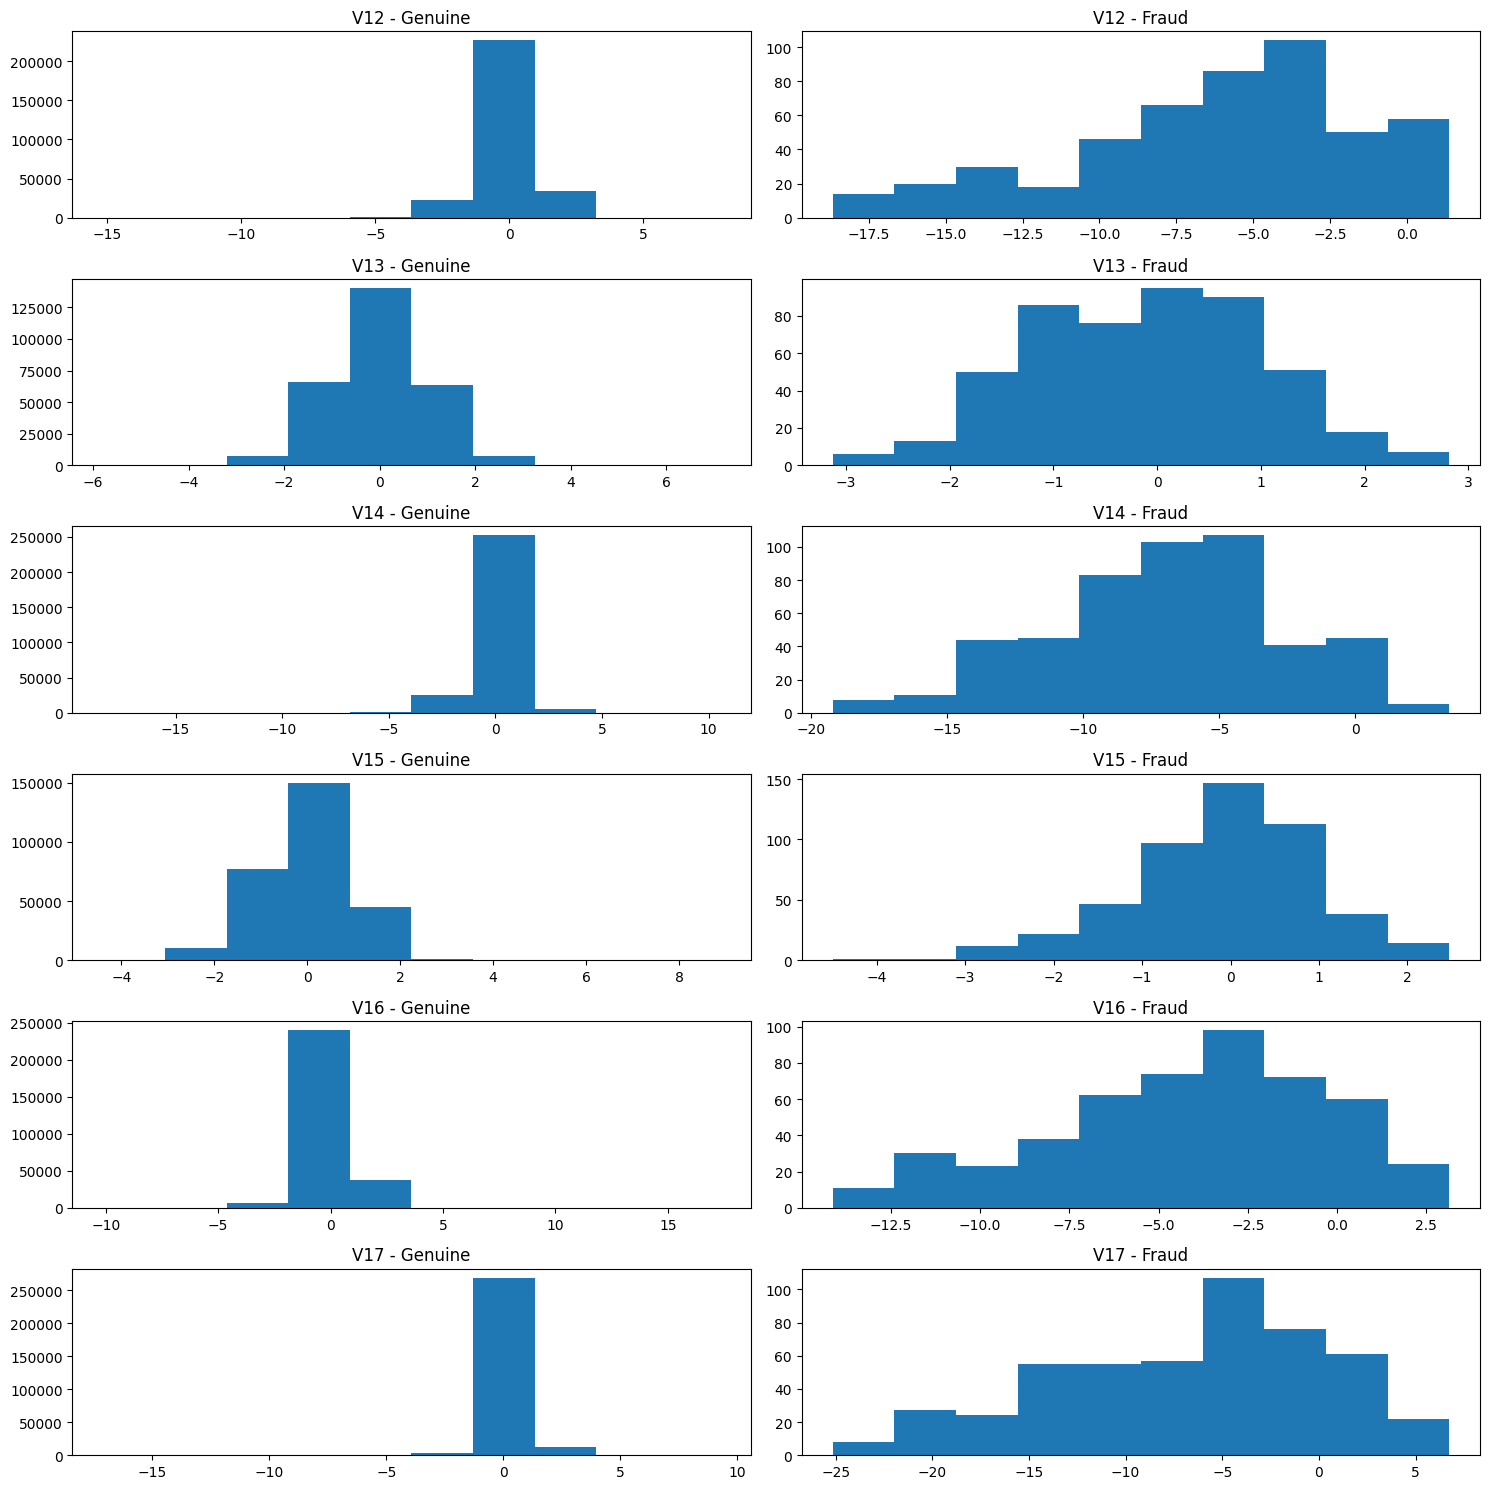

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
for i in range(list_col[1],list_col[2]):
  r = (i - list_col[1]) % 6
  plot_hist(r,i)
  fig.tight_layout()

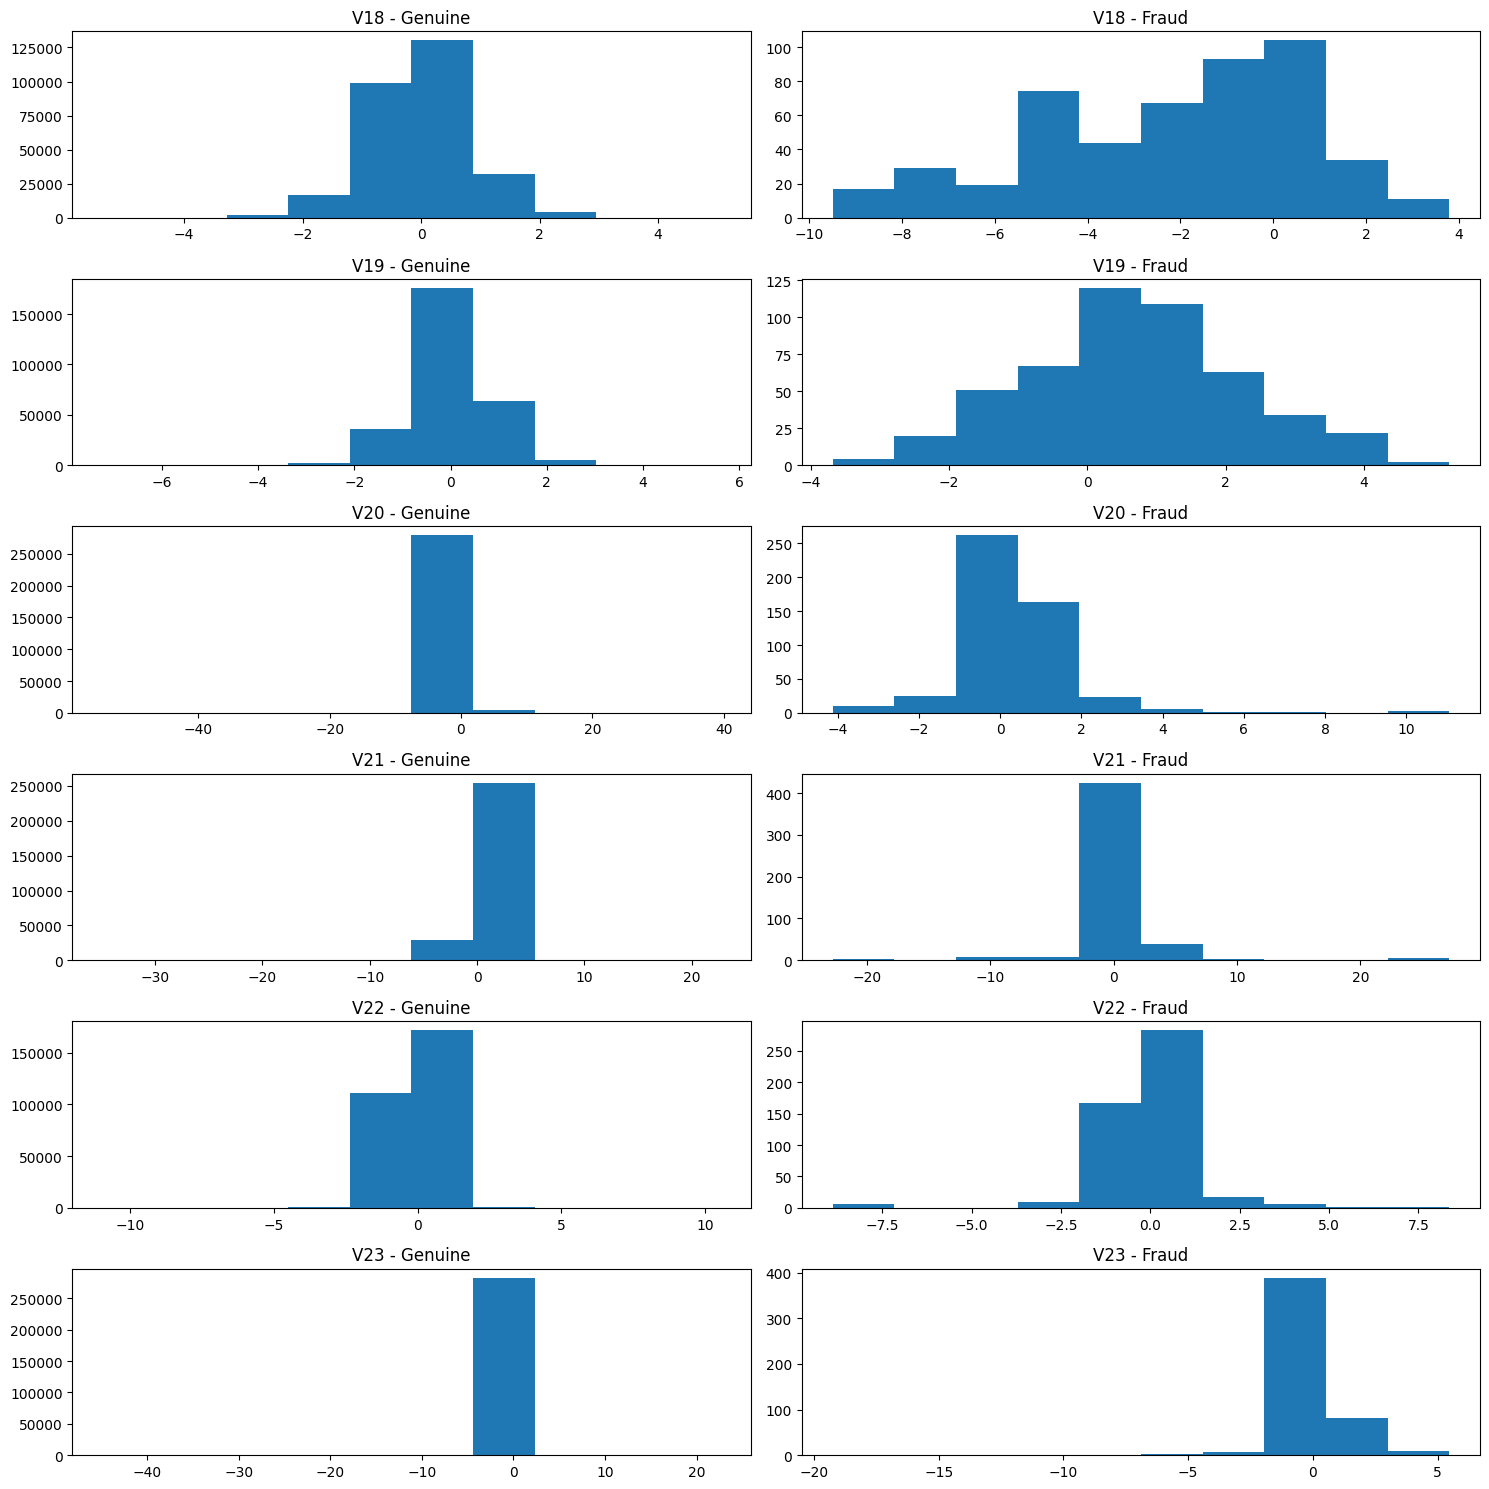

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
for i in range(list_col[2],list_col[3]):
  r = (i - list_col[1]) % 6
  plot_hist(r,i)
  fig.tight_layout()

Amount : Interestingly, majority of the fraudulent transactions are <500. This is suprising as I would imagine the fraudulent transactions to be of a higher amount.

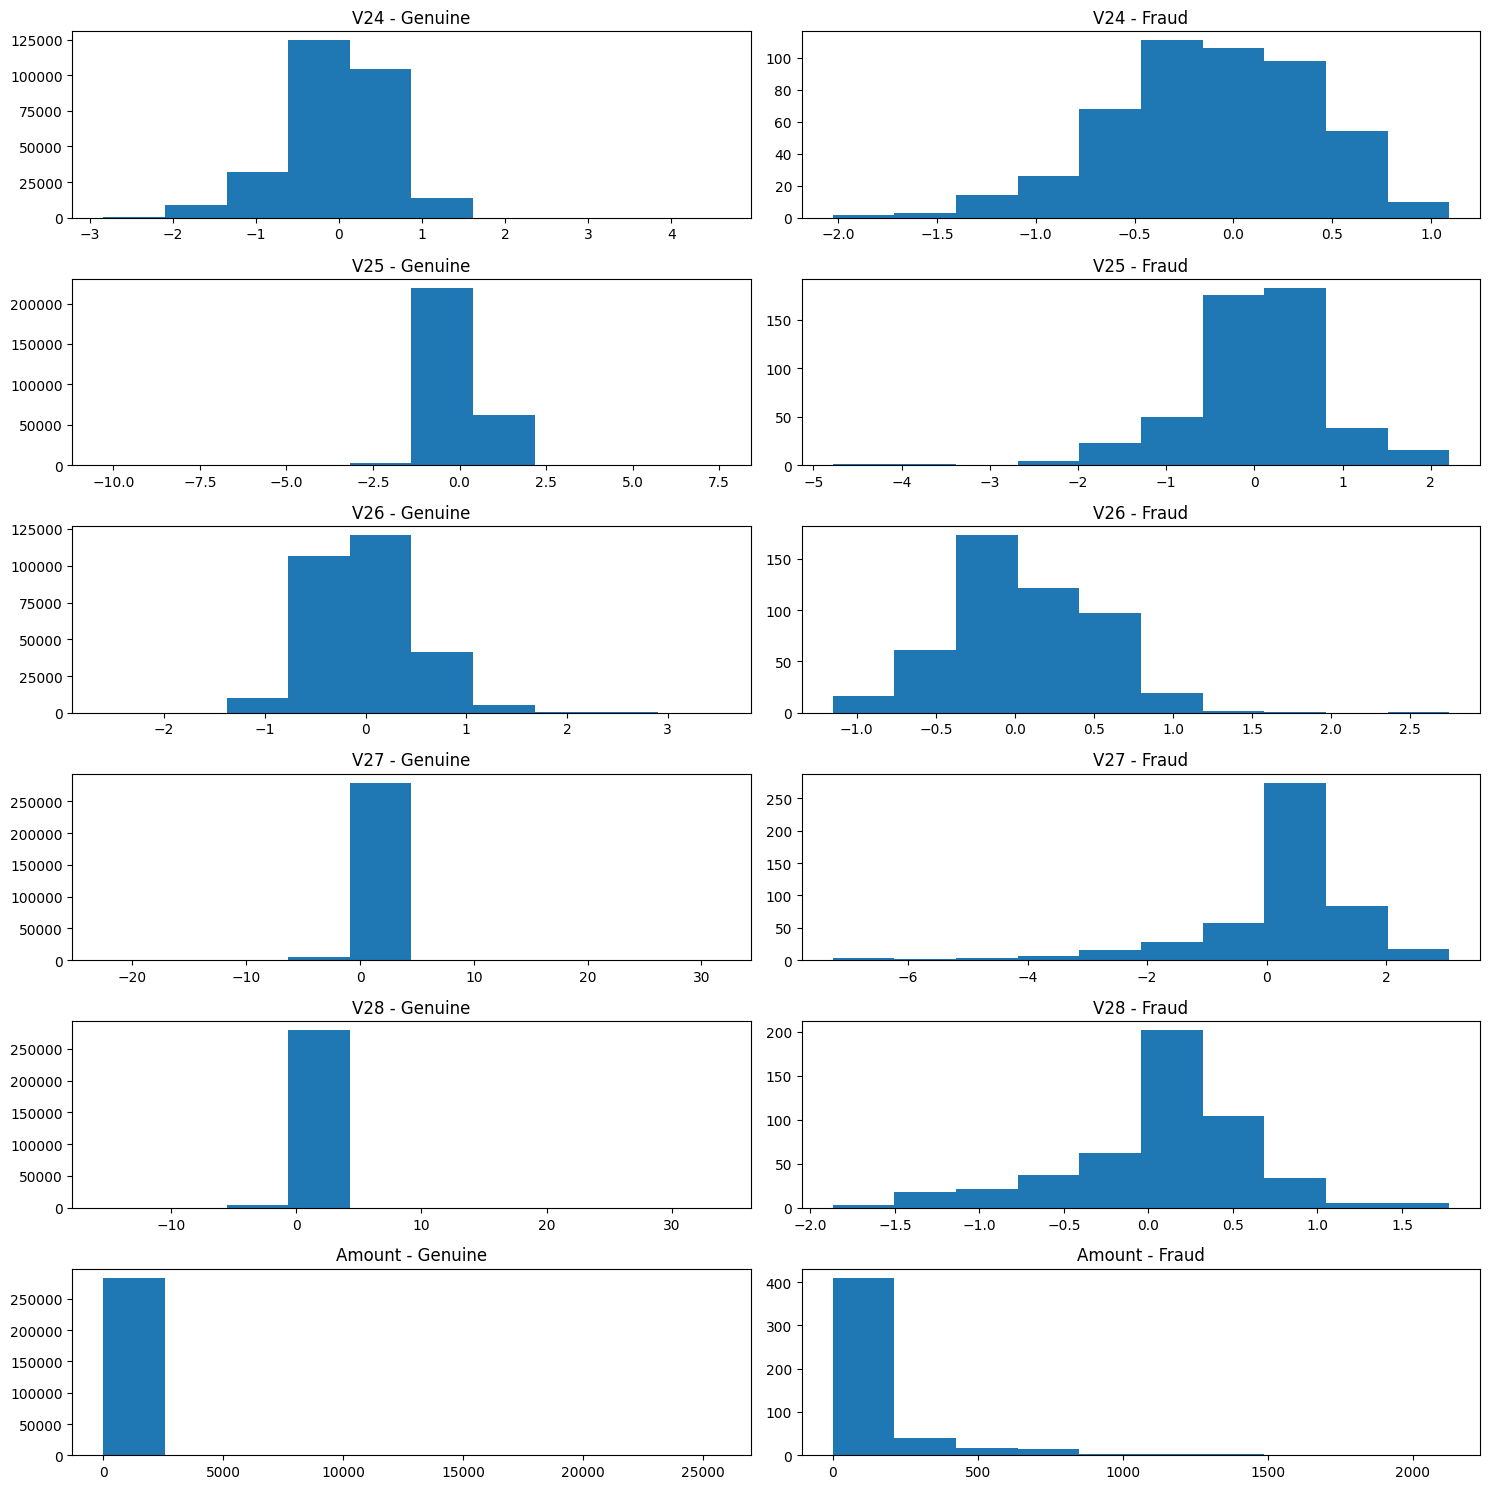

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
for i in range(list_col[3],list_col[4]):
  r = (i - list_col[1]) % 6
  plot_hist(r,i)
  fig.tight_layout()

From the graphical visualization of the data distribution, we can see that there are generally no clear indicators that is able to clearly segregate the fraudulent transactions from the genuine transactions. This is a common problem in reality.

The variables which I think there might be a chance of doing so are V11 and V14, so we will see if these 2 are indeed useful indicators or not later on.

In [3]:
# Process the actual labels to match the label output of the Isolation Forest Model
y = df['Class']
y_act = [-1 if x == 1 else x for x in y]
y_act = [1 if x == 0 else x for x in y_act]

# Training Isolation Forest Machine Learning Model with results

Now, we are ready to train the Isolation Forest Machine Learning Model. For the first run, we will only be using the PCA variables from V1 t0 V28 as data inputs only. We will drop the columns Time, Amount and Class.

We will train the model with some hyperparameter inputs and print the classification report. From the classification report, we can view the precision, recall and f1-score of the model.

In [4]:
# Preparing data input
df_is_1 = df.copy()
df_is_1.drop(['Time', 'Amount', 'Class'], axis=1, inplace=True)

# Training the data and printing the classification report
clf_1 = IsolationForest(n_estimators=100, max_samples=1000, contamination = 0.0017, random_state=0)
clf_1.fit(df_is_1)
y_pred = clf_1.predict(df_is_1)

print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

          -1       0.36      0.35      0.36       492
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    284807
   macro avg       0.68      0.68      0.68    284807
weighted avg       1.00      1.00      1.00    284807



In [ ]:
# Inspect parameters of the model
clf_1.get_params()

{'bootstrap': False,
 'contamination': 0.0017,
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

# Feature Importance

After training the model, we can run it through SHAP explainer to inspect the feature importance of the model.

Isolation Forest model produces the labels 1 and -1. The features of high importance will have a more negative SHAP value. For example, taking feature V19, a more negative value will lead to high predictability of anomaly.

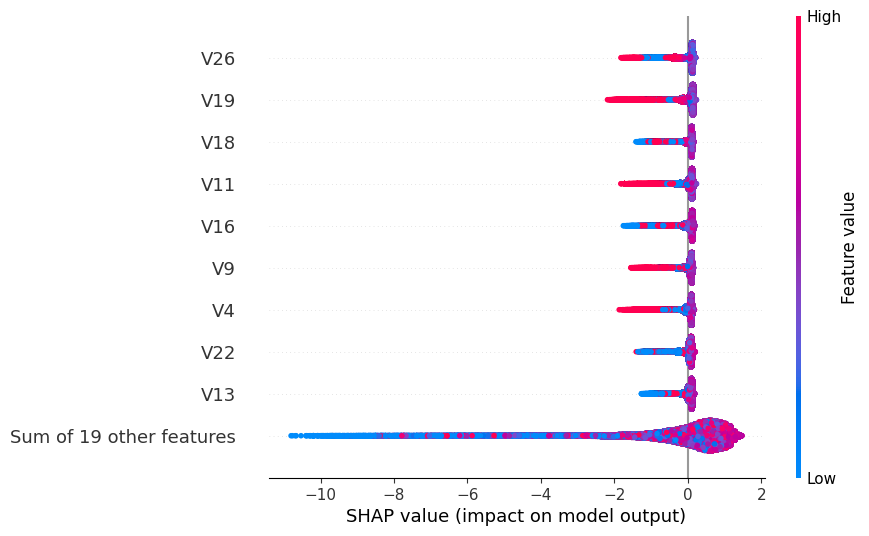

In [ ]:
# Preparing the model for SHAP explainer
explainer = shap.Explainer(clf_1)
shap_values = explainer(df_is_1)

# Display the beeswarm plot of the variables
shap.plots.beeswarm(shap_values, plot_size=[8,6])

We can run the following codes to check how the features contribute to the model predicted label.

In [ ]:
# Inspecting some values of model predictions
indices = [i for i, x in enumerate(y_act) if x == -1]
print(indices[:10])
print([i for i in y_pred[indices[:10]]])
print([i for i in clf_1.decision_function(df_is_1.loc[indices[:10]])])
print([i for i in clf_1.score_samples(df_is_1.loc[indices[:10]])])

[541, 623, 4920, 6108, 6329, 6331, 6334, 6336, 6338, 6427]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[np.float64(0.15367102456607895), np.float64(0.232591898865402), np.float64(0.16791069750772342), np.float64(0.030870293198391963), np.float64(0.07343799719022903), np.float64(0.04385403041625546), np.float64(0.04062061264743133), np.float64(0.07074056566260556), np.float64(0.06138953393523616), np.float64(0.023766485245467317)]
[np.float64(-0.5009446475391163), np.float64(-0.42202377323979323), np.float64(-0.4867049745974718), np.float64(-0.6237453789068033), np.float64(-0.5811776749149662), np.float64(-0.6107616416889398), np.float64(-0.6139950594577639), np.float64(-0.5838751064425897), np.float64(-0.5932261381699591), np.float64(-0.6308491868597279)]


Sample index : 6108
Actual label : -1
Predicted label : 1


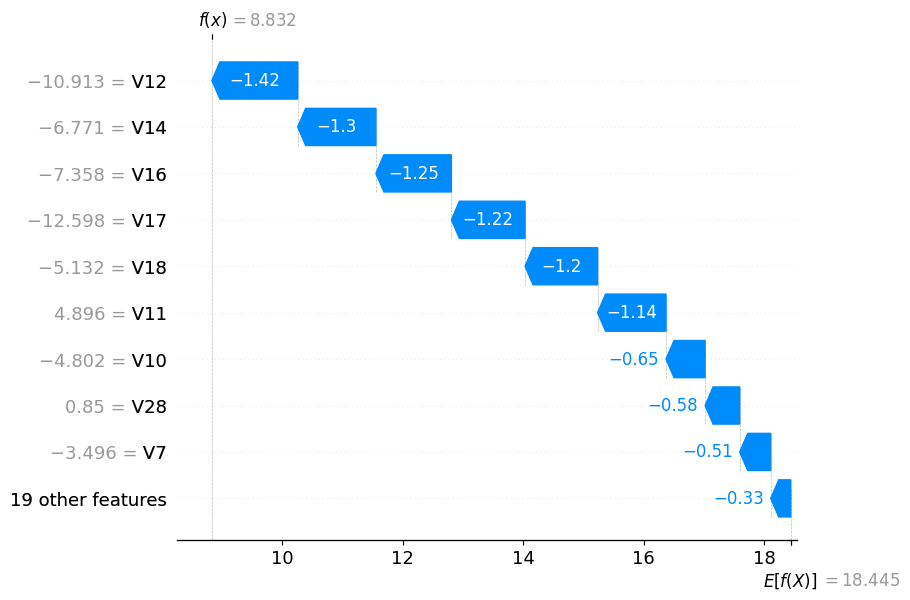

In [ ]:
# Displaying the waterfall of each variable's SHAP value's contribution
a = 6108
print(f'Sample index : {a}')
print(f'Actual label : {y_act[a]}')
print(f'Predicted label : {y_pred[a]}')
shap.plots.waterfall(shap_values[a], max_display=10)

Precision Recall AUC : 0.99


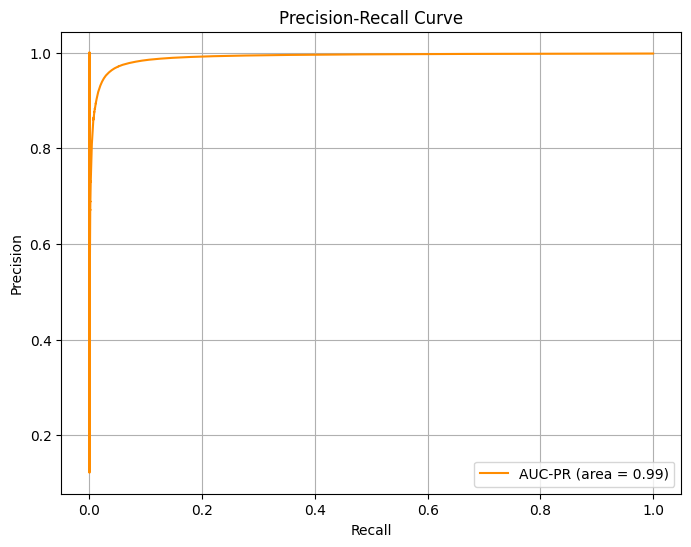

In [9]:
# Plotting the Precision Recall Curve
y_pred_score = -clf_1.decision_function(df_is_1)
precision, recall, thresholds = precision_recall_curve(y_act, y_pred_score)

auc_pr = auc(recall, precision)
print(f'Precision Recall AUC : {auc_pr:.2f}')

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', label=f'AUC-PR (area = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Inspecting the values of the curve
p_i = [i for i, x in enumerate(precision) if x == 1]
print(p_i)
print(recall[p_i])
print(precision[p_i])

[255086, 255087]
[3.51722561e-06 0.00000000e+00]
[1. 1.]


# Training Isolation Forest Machine Learning Model v2 with results

We have trained the first Isolation Forest ML model and analyzed the results. We can try training a second Isolation Forest ML model and see if we can squeeze any improvements in the model. This time, we will be including the Amount column for data. However, we apply standard scaling to the Amount column.

From the classification report, we can see that the inclusion of this variable has actually resulted in a slight dip in model performance.


In [ ]:
# Preprocessing for the column Amount
df_is_2 = df.copy()
df_is_2.drop(['Time', 'Class'], axis=1, inplace=True)
df_is_2['Amount'] = StandardScaler().fit_transform(df_is_2[['Amount']])

# Training the data and printing the classification report
clf_2 = IsolationForest(n_estimators=1000, max_samples=1000, contamination = 0.0017, random_state=0)
clf_2.fit(df_is_2)
y_pred = clf_2.predict(df_is_2)

print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

          -1       0.32      0.31      0.31       492
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    284807
   macro avg       0.66      0.65      0.66    284807
weighted avg       1.00      1.00      1.00    284807



# Additional Feature Engineering / Preprocessing

If you have domain knowledge, you can try to create additional features which can be used as additional inputs for model training. One such example could be to create some features around enumeration or bin attacks for credit card fraud. We could risk rank clusters and bin by time buckets where there are higher number of credit card transactions and see if there is a higher number of fraudulent transactions as well.